# Processor Data Analysis Notebook

In [1]:
processor_data_path = None

In [43]:
# Validate parameters
assert processor_data_path is not None, 'Must set parameter for path to processor data json file'

## Load Processor Data

In [42]:
from codex.ops import op, best_focus, deconvolution, drift_compensation, tile_summary
from IPython import display
import plotnine as pn
import pandas as pd
import json

# Set expected keys for operations dynamically based on class names (to avoid
# future refactoring synchronization problems)
drift_comp_op = op.CodexOp.get_op_for_class(drift_compensation.CodexDriftCompensator)
best_focus_op = op.CodexOp.get_op_for_class(best_focus.CodexFocalPlaneSelector)
tile_summary_op = op.CodexOp.get_op_for_class(tile_summary.CodexTileSummary)

# Load processor data as a dict of data frames, separated by operation type
with open(processor_data_path, 'r') as fd:
    data = json.load(fd)
    data = {k: pd.DataFrame(v) for k, v in data.items()}

In [6]:
# Display the head rows for each operation type
for k in data:
    display.display(data[k].head().style.set_caption(k))

,region,target_cycle,tile,tile_x,tile_y,time,translation
0,0,1,0,0,0,0.867208,"[-1, -1, -6]"
1,0,1,1,1,0,0.871387,"[-1, -1, -6]"
2,0,1,2,1,1,0.839781,"[-1, -1, -6]"
3,0,1,3,0,1,0.82163,"[-1, -1, -6]"
4,0,1,4,0,2,0.83794,"[-1, -1, -6]"


,best_z,classifications,region,tile,tile_x,tile_y,time
0,2,"[10, 10, 2, 2, 10]",0,0,0,0,0.339087
1,2,"[10, 10, 2, 10, 10]",0,1,1,0,0.323714
2,1,"[2, 2, 9, 2, 2]",0,2,1,1,0.328956
3,2,"[2, 2, 2, 2, 2]",0,3,0,1,0.300774
4,2,"[9, 2, 2, 2, 9]",0,4,0,2,0.307659


,region,slice,tile,tile_x,tile_y,time
0,0,"['slice(30, 267, None)', 'slice(15, 351, None)']",0,0,0,3.4899e-05
1,0,"['slice(30, 267, None)', 'slice(15, 351, None)']",1,1,0,3.67169e-05
2,0,"['slice(30, 267, None)', 'slice(15, 351, None)']",2,1,1,2.799e-05
3,0,"['slice(30, 267, None)', 'slice(15, 351, None)']",3,0,1,2.51001e-05
4,0,"['slice(30, 267, None)', 'slice(15, 351, None)']",4,0,2,2.88421e-05


,region,tile,tile_x,tile_y,time
0,0,0,0,0,0.0268947
1,0,1,1,0,0.0284198
2,0,2,1,1,0.0293807


,channel,max,mean,min,region,std,tile,tile_x,tile_y,time
0,CH-0-0,2362,600.032,224,0,297.338,0,0,0,0.0121425
1,CH-0-1,2362,600.032,224,0,297.338,0,0,0,0.0121425
2,CH-1-0,0,0,0,0,0,0,0,0,0.0121425
3,CH-1-1,0,0,0,0,0,0,0,0,0.0121425
4,CH-0-0,2601,482.838,232,0,247.791,1,1,0,0.0133098


### Drift Compensation Summary

In [18]:
df = data[drift_comp_op].copy()
df = df.groupby(['region', 'target_cycle'])['translation'].first().reset_index()
for i, dim in enumerate(['z', 'y', 'x']):
    df['delta_' + dim] = df['translation'].apply(lambda v: v[i])
df

,region,target_cycle,translation,delta_z,delta_y,delta_x
0,0,1,"[-1, -1, -6]",-1,-1,-6


### Focal Plane Summary

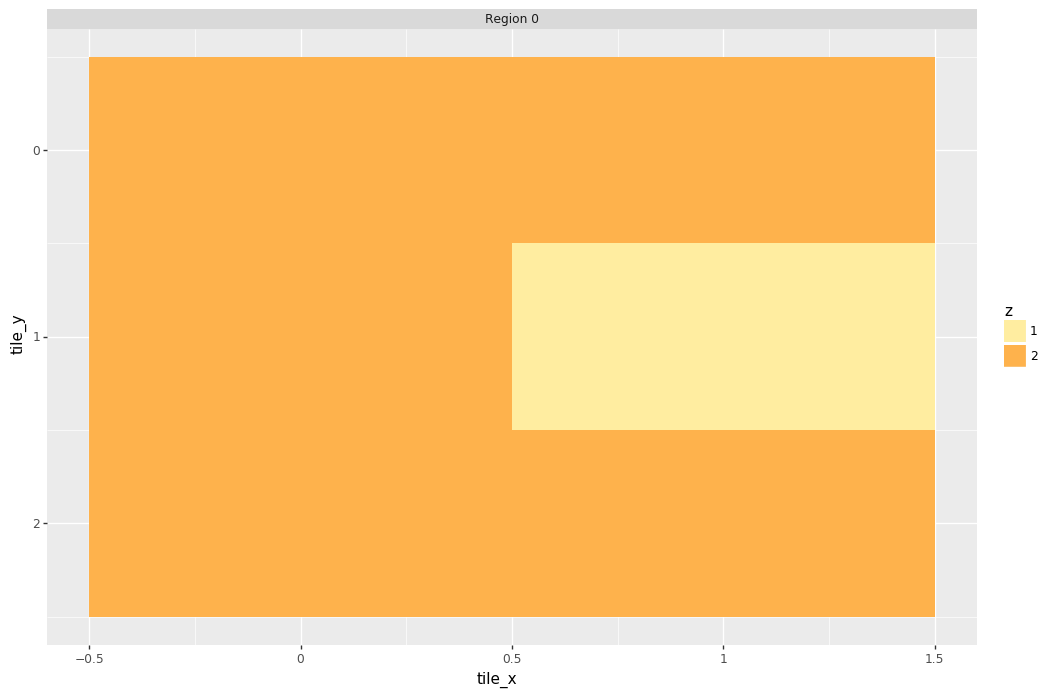

<ggplot: (294691504)>

In [33]:
df = data[best_focus_op].copy()
(
    pn.ggplot(
        df.assign(
            z=df['best_z'].apply(lambda v: '{}'.format(v)),
            region_index=df['region'].apply(lambda v: 'Region {}'.format(v))
        ), 
        pn.aes(x='tile_x', y='tile_y', fill='z')
    ) +
    pn.scale_y_reverse() +
    pn.scale_fill_brewer(palette='YlOrRd') +
    pn.facet_wrap('~region_index', ncol=2) +
    pn.geom_tile() + 
    pn.theme(figure_size=(12, 8))
)

### Tile Summary Statistics

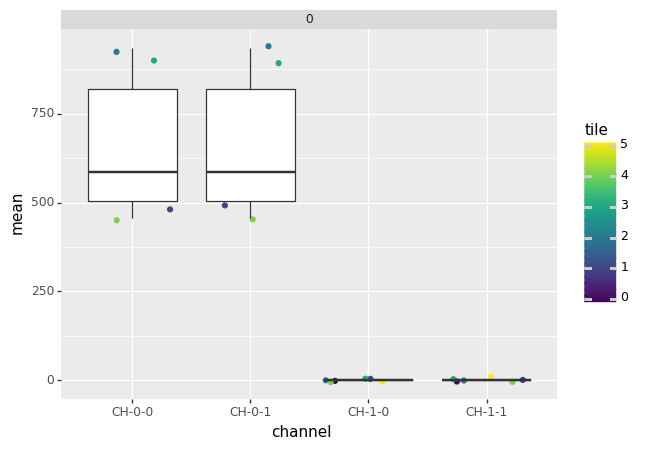

<ggplot: (295537556)>

In [41]:
df = data[tile_summary_op].copy()
(
    pn.ggplot(
        df.assign(region_index=df['region'].apply(lambda v: 'Region {}'.format(v))), 
        pn.aes(x='channel', y='mean')
    ) + 
    pn.geom_jitter(pn.aes(color='tile')) +
    pn.geom_boxplot(outlier_size=0) +
    pn.facet_wrap('~region')
)